In [44]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import numpy as np
from src.classes.ClassFractionalQuadSin import FractionalQuadSin
from tqdm import tqdm
from configs.RecursiveVPSDE.LSTM_fQuadSinHF.recursive_LSTM_PostMeanScore_fQuadSinHF_T256_H05_tl_110data import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# From A ridge estimator of the drift from discrete repeated observations of the solutions of a stochastic differential equation (Denis et al 2021)

In [45]:
config = get_config()

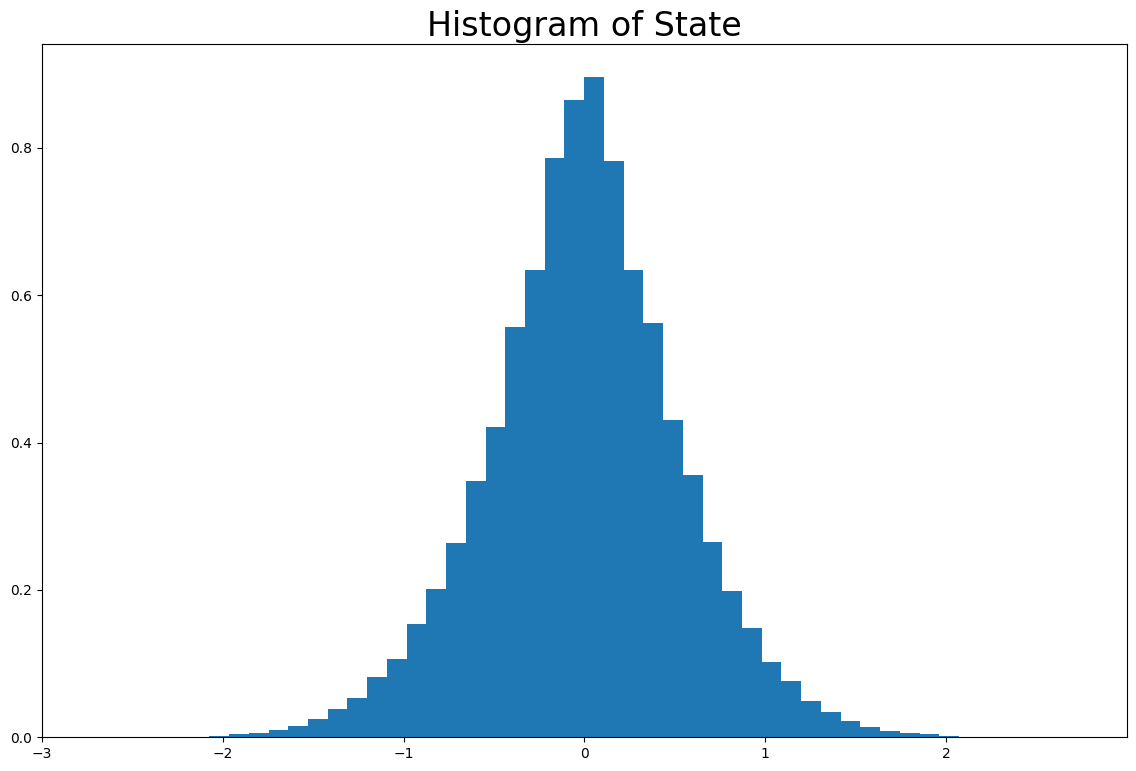

In [46]:
num_paths = 10952
num_time_steps = config.ts_length
isUnitInterval = True
diff = config.diffusion
initial_state = config.initState
rvs = None
H = config.hurst
deltaT = config.deltaT
t0 = config.t0
t1 = deltaT * num_time_steps
fQuadSin = FractionalQuadSin(quad_coeff=config.quad_coeff, sin_coeff= config.sin_coeff, sin_space_scale=config.sin_space_scale, diff=diff, X0=initial_state)
paths = np.array(
    [fQuadSin.euler_simulation(H=H, N=num_time_steps, deltaT=deltaT, isUnitInterval=isUnitInterval, X0=initial_state, Ms=None, gaussRvs=rvs,
                           t0=t0, t1=t1) for _ in (range(num_paths))]).reshape(
    (num_paths, num_time_steps+1))
fig, ax = plt.subplots(figsize=(14,9))
plt.hist(paths.flatten(), bins=50, density=True)
plt.title("Histogram of State", fontsize=24)
plt.show()
plt.close()

In [47]:
print(np.min(paths), np.max(paths))
for k in range(num_paths, 1000):
    plt.plot(np.arange(1, 258), paths[k,:])
plt.show()

-2.728160800466824 2.7251413976498666


In [48]:
def spline_basis(paths, KN, AN, BN, M):
    assert (paths.shape[0] >= 1 and len(paths.shape)==2)
    assert (AN < BN and KN > 0 and M > 0)
    def construct_ith_knot(i, AN, BN, KN):
        if i < 0:
            return AN
        elif i > KN:
            return BN
        else:
            return AN + i*(BN-AN)/KN
    def bspline(i, l, u, x, KN, M):
        if l == 0 and -M <= i <= KN+M-1:
            return ((u[i] <= x) & (x < u[i+1])).astype(float)
        elif 1 <= l <= M  and -M <= i <= KN+M-l-1:
            num1 = ((x-u[i])/(u[i+l]-u[i]))
            num1[np.isinf(num1)] = 0.
            num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
            num2[np.isinf(num2)] = 0.
            return num1*bspline(i=i,l=l-1, u=u, x=x, KN=KN, M=M)+num2*bspline(i=i+1, l=l-1, u=u, x=x, KN=KN, M=M)

    knots = {i:construct_ith_knot(i, AN, BN, KN) for i in range(-M, KN+M+1)}
    if paths.shape[1] > 1:
        paths = paths[:,:-1].flatten()
    else:
        paths = paths.flatten()
    basis = np.array([bspline(i=i, l=M, u=knots, x=paths, KN=KN,M=M) for i in range(-M, KN)]).T
    assert (basis.shape == (paths.shape[0], KN+M)), f"Basis is shape {basis.shape} but should be {(paths.shape[0], KN+M)}"
    assert np.all(basis >= 0.)
    return basis

import scipy
def find_optimal_estimator_coeffs(B, Z, KN, LN, M):
    # Precompute certain matrices
    BTB = B.T@B
    BTZ = (B.T@Z)
    const = (KN+M)*LN
    if np.all(np.linalg.eigvalsh(BTB)>0.):
        print(f"Matrix BTB is invertible\n")
        a = np.linalg.inv(BTB)@BTZ
        if a.T@a <= const:
            print(f"L2 norm of coefficients automatically satisfies projection constraint\n")
            return a
    I = np.eye(KN+M)
    def obj(l):
        inv = np.linalg.inv(BTB+l*I) @ BTZ
        return np.abs(inv.T@inv - const)
    opt = scipy.optimize.minimize(obj, max(0.,-np.min(np.linalg.eigvalsh(BTB)))+1e-12)
    lhat = np.inf
    while not (opt.success) and not np.allclose(lhat, opt.x):
        lhat = opt.x
        opt = scipy.optimize.minimize(obj, opt.x)
    lhat = opt.x[0]
    a = np.atleast_2d(np.linalg.inv(BTB+lhat*I)@BTZ)
    print(a.T@a, const)
    #assert (np.allclose(a.T@a , const))
    return a

def construct_estimator(coeffs, B, LN):
    drift  = B@coeffs
    drift[np.abs(drift) > np.sqrt(LN)] = np.sqrt(LN)*np.sign(drift[np.abs(drift) > np.sqrt(LN)])
    return drift

def true_drift(prev, num_paths, config):
    assert (prev.shape == (num_paths, config.ndims))
    drift_X = -2. * config.quad_coeff * prev + config.sin_coeff * config.sin_space_scale * np.sin(
        config.sin_space_scale * prev)
    return drift_X[:, np.newaxis, :]

def plot_errors(config, true_states, global_states, local_states, KN):
    true_states /= np.sqrt(config.deltaT)
    global_states/= np.sqrt(config.deltaT)
    local_states/= np.sqrt(config.deltaT)
    local_errors = np.power(np.cumsum(np.mean(np.power(true_states- local_states,2), axis=0), axis=0), 0.5) #/np.arange(1, local_states.shape[1]+1)[:, np.newaxis]
    #global_errors = np.power(np.mean(np.power(true_states- global_states,2), axis=0), 0.5)
    fig, ax = plt.subplots(figsize=(14,9))
    total_local_errors = np.power(np.sum(np.power(local_errors, 2), axis=1)/np.arange(1, local_errors.shape[0]+1), 0.5)
    #total_global_errors = np.power(np.sum(np.power(global_errors, 2), axis=1), 0.5)
    ax.scatter(np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0]), total_local_errors)
    ax.set_title(f"Cumulative Errors for Ridge Estimator",fontsize=40)
    ax.set_ylabel("RMSE", fontsize=38)
    ax.set_xlabel("Time Axis", fontsize=38)
    ax.tick_params(labelsize=38)
    plt.tight_layout()
    save_path = f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/"
    for f in os.listdir(save_path):
        if "Ridge_DriftTrack_fQuadSinHF_" in f and f"{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c" in f:
            os.remove(save_path + f)
    plt.savefig(save_path + f"Ridge_DriftTrack_fQuadSinHF_{KN}KN_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c.png",  bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Final time cumulative local-time error {total_local_errors[-1]} at KN {KN}\n")

In [49]:
config.data_path

'/Users/marcos/GitHubRepos/FractionalBrownianMotion/data/fQuadSinHF_samples_t00_dT3906e-03_T256_05a_004b_250c_10Diff_00Init.npy'

In [50]:
AN = np.min(paths)-0.5
BN = -AN
M = 3
LN = np.log(num_paths)
AN

-3.228160800466824

In [51]:
num_time_steps = 100
num_state_paths = 100
rmse_quantile_nums = 20
KNS = [2,3,4,5,6,7,8,9,10,20,25,30, 35, 40, 45, 50, 55]

/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))


Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 20/20 [00:01<00:00, 13.35it/s]


0.04371945025967295 (0.043361526000570964, 0.043953107411580004) inf


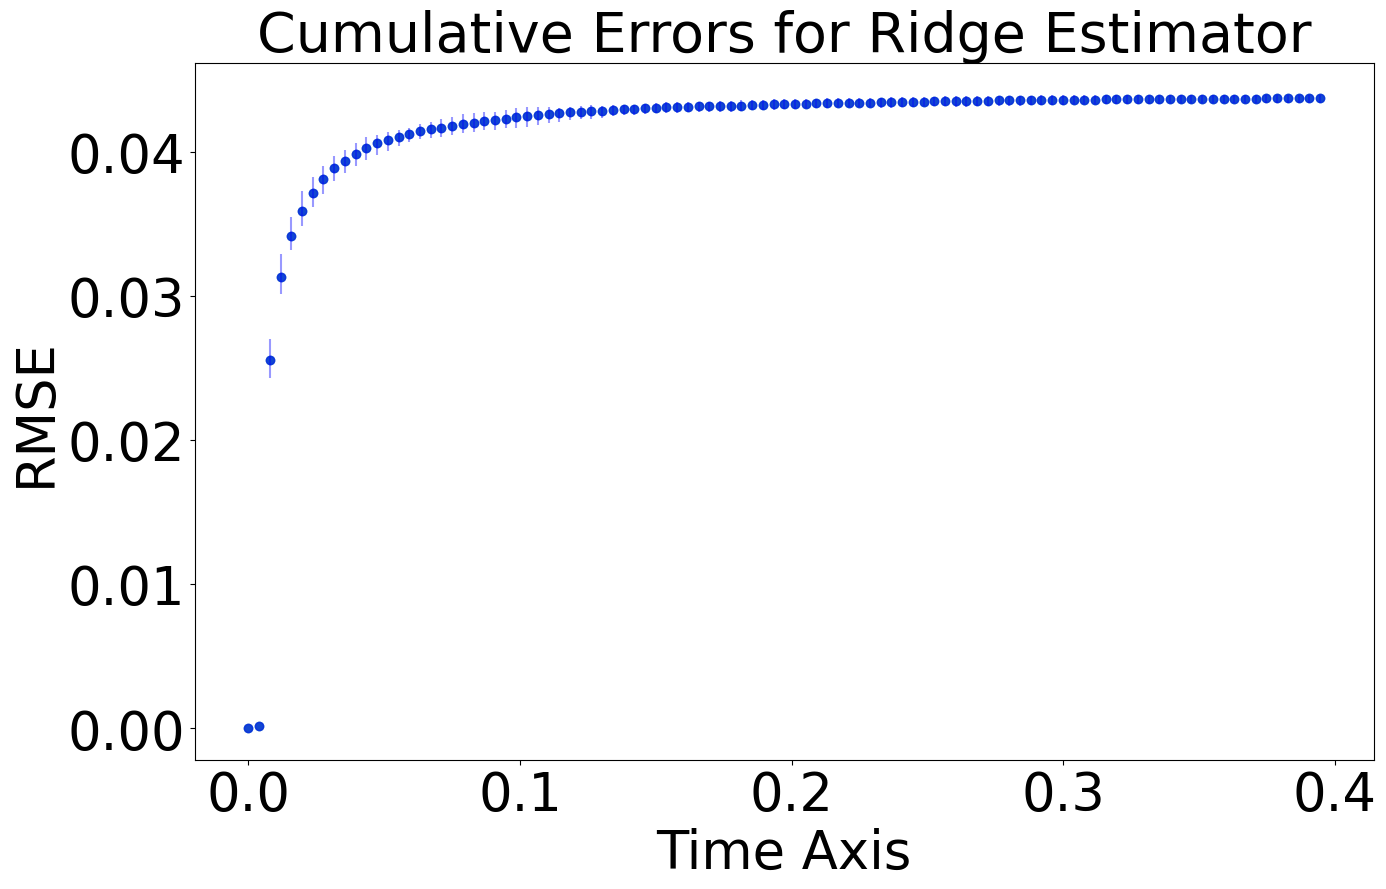

Final time cumulative RMSE local-time error 0.04371945025967295 with IQR (0.043361526000570964, 0.043953107411580004) at KN 2

Matrix BTB is invertible

[[48.44837006]] 55.8076642018097


  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:01<00:00, 13.65it/s]


0.043750113502823436 (0.04344642114593557, 0.04411782742703901) 0.04371945025967295
Matrix BTB is invertible

[[65.10894162]] 65.108941568778


  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:01<00:00, 12.35it/s]


0.04380368059961675 (0.0436172422889455, 0.044027905075388715) 0.04371945025967295
Matrix BTB is invertible

[[74.41021907]] 74.41021893574627


  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:01<00:00, 11.22it/s]


0.043804788557206716 (0.043548478821223605, 0.0441117725429225) 0.04371945025967295
Matrix BTB is invertible

[[83.71149645]] 83.71149630271455


  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


0.04373464931569036 (0.04349535928159036, 0.043966852312044453) 0.04371945025967295
Matrix BTB is invertible

[[93.01277392]] 93.01277366968284


  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:02<00:00,  9.19it/s]


0.04371776644287529 (0.04348797434357668, 0.043976866194643305) 0.04371945025967295


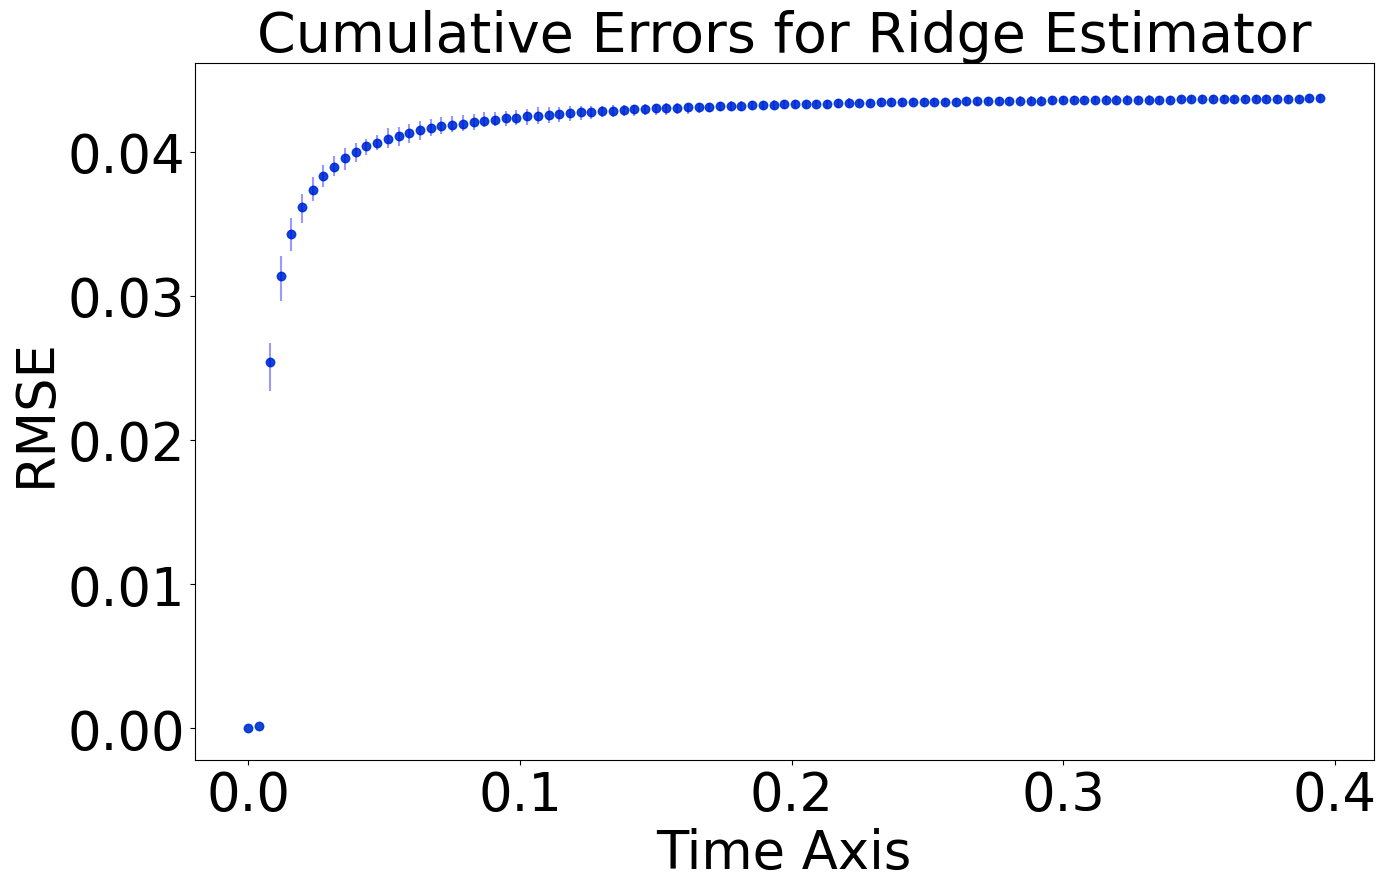

Final time cumulative RMSE local-time error 0.04371776644287529 with IQR (0.04348797434357668, 0.043976866194643305) at KN 7

Matrix BTB is invertible

[[102.31405201]] 102.31405103665112


  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


0.04384676790963486 (0.043593448694155316, 0.0441952954326793) 0.04371776644287529
Matrix BTB is invertible

[[73.73846245]] 111.6153284036194


  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:02<00:00,  8.32it/s]


0.04374603285063126 (0.04340239438380535, 0.0439813167373936) 0.04371776644287529
Matrix BTB is invertible

[[120.91660601]] 120.9166057705877


  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:02<00:00,  7.91it/s]


0.043720818333721066 (0.04337494894294546, 0.043990750387196645) 0.04371776644287529
[[213.92938013]] 213.92937944027054


  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:04<00:00,  4.23it/s]


0.043850844036004706 (0.04356870202921841, 0.044100391015576786) 0.04371776644287529
[[260.43576669]] 260.435766275112


  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:07<00:00,  2.60it/s]


0.04379237991742323 (0.04345748835345263, 0.04405620341663396) 0.04371776644287529
[[306.94215394]] 306.9421531099534


  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:07<00:00,  2.56it/s]


0.04379610528166755 (0.04351091142588024, 0.04406281810873343) 0.04371776644287529
[[353.4485406]] 353.4485399447948


  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:07<00:00,  2.64it/s]


0.04363634858985384 (0.04342022092335691, 0.04384134318813778) 0.04371776644287529


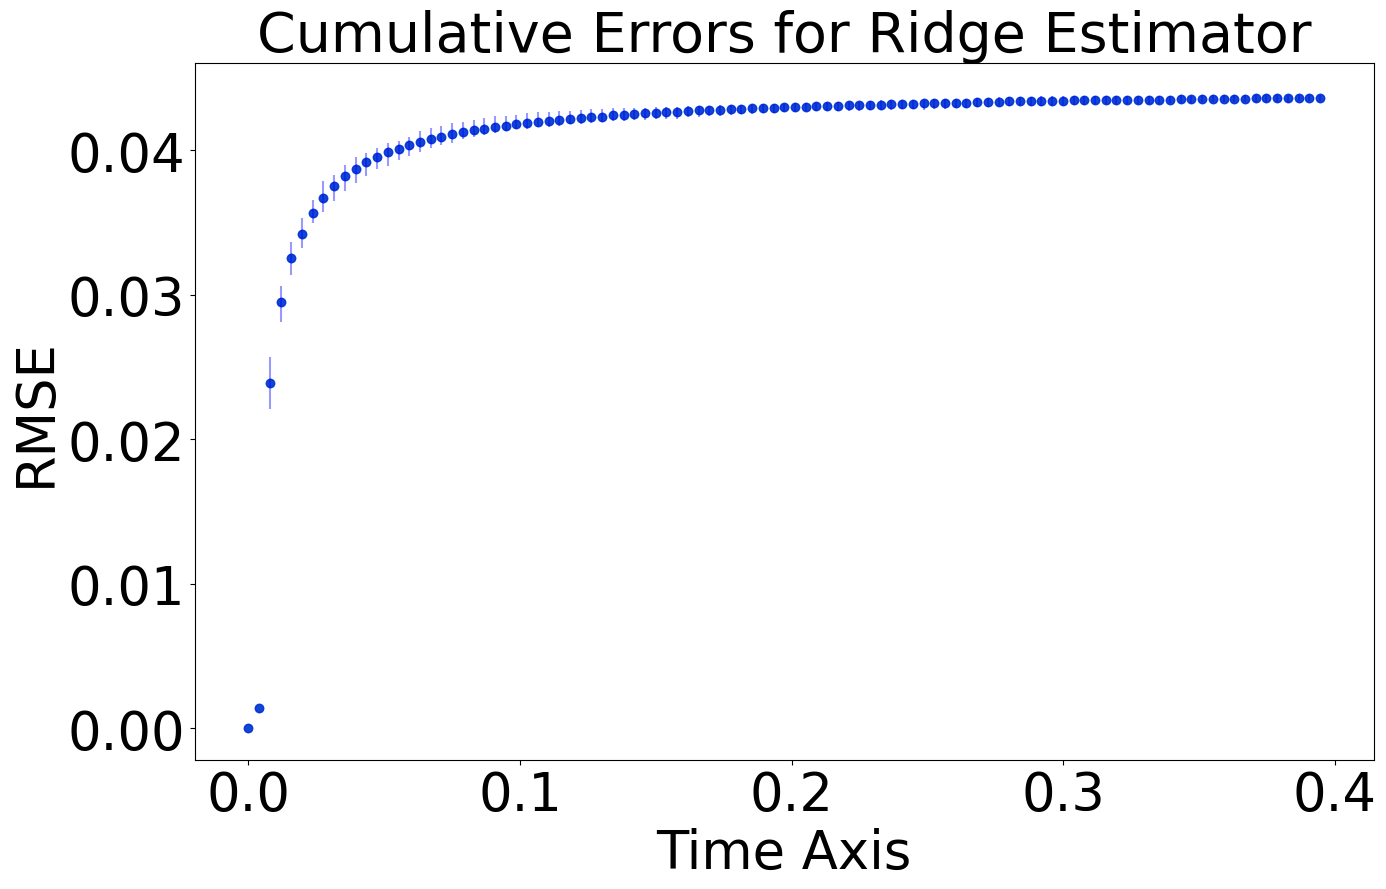

Final time cumulative RMSE local-time error 0.04363634858985384 with IQR (0.04342022092335691, 0.04384134318813778) at KN 35

[[399.95492746]] 399.9549267796362


  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:08<00:00,  2.39it/s]


0.04357693445162107 (0.043148247689661336, 0.0439091655713225) 0.04363634858985384


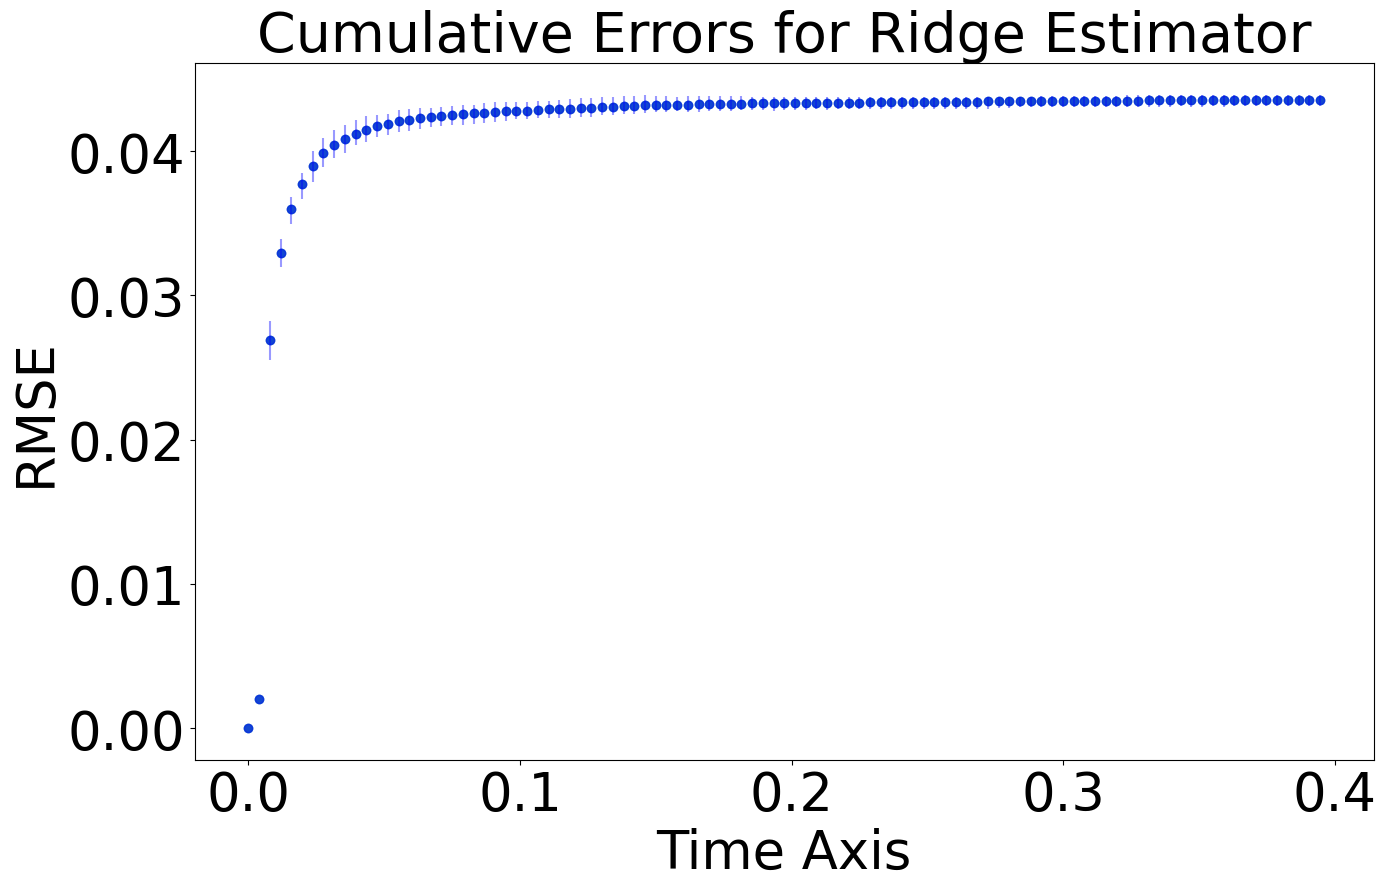

Final time cumulative RMSE local-time error 0.04357693445162107 with IQR (0.043148247689661336, 0.0439091655713225) at KN 40

[[446.46131522]] 446.4613136144776


  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:09<00:00,  2.14it/s]


0.03716134239489497 (0.03623284249959383, 0.038162277458680456) 0.04357693445162107


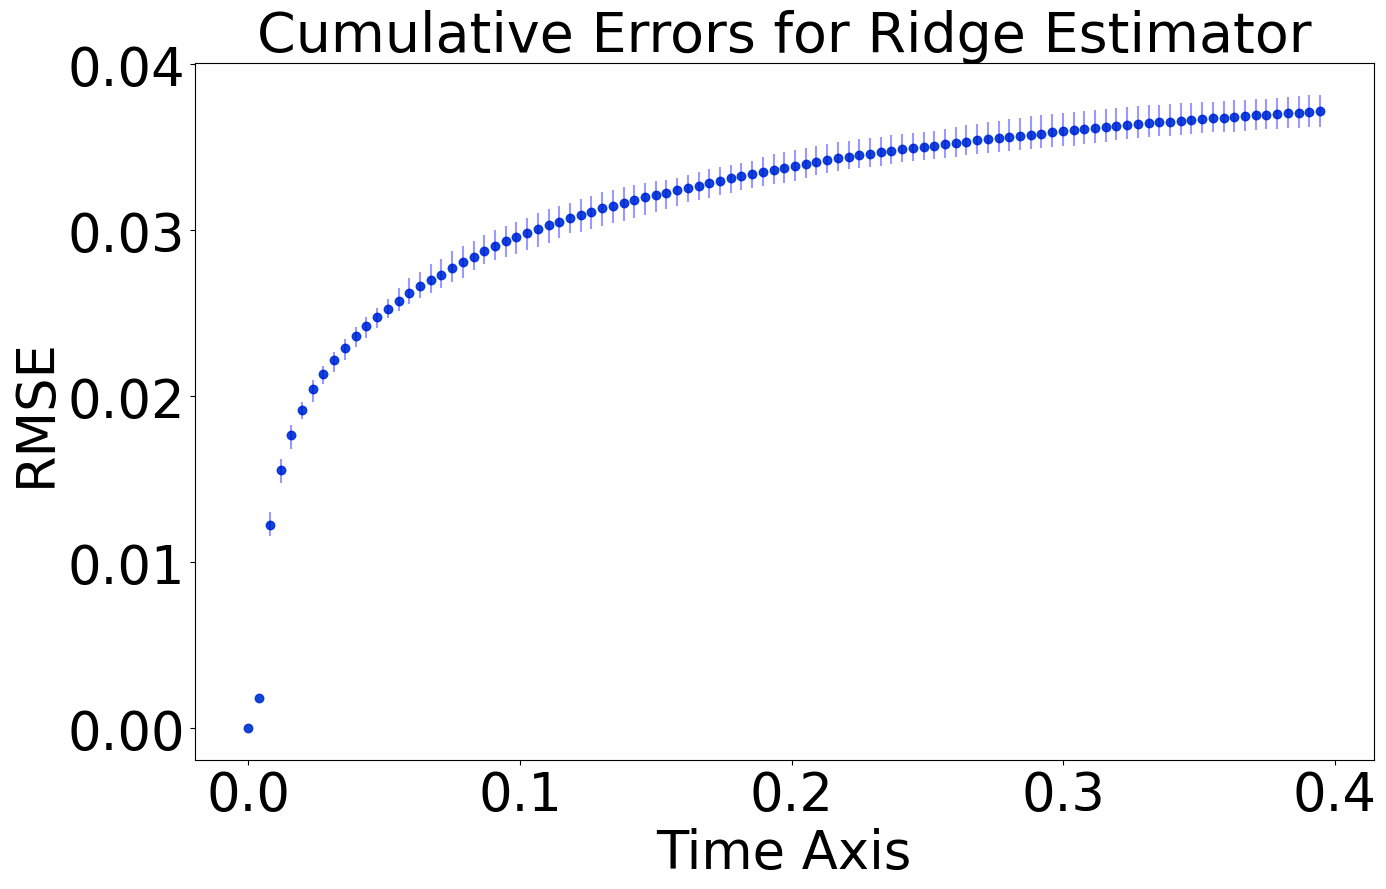

Final time cumulative RMSE local-time error 0.03716134239489497 with IQR (0.03623284249959383, 0.038162277458680456) at KN 45

[[492.96770199]] 492.96770044931907


  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:11<00:00,  1.71it/s]


0.043547383706815684 (0.04319716661715647, 0.04398112318693874) 0.03716134239489497
[[539.47408764]] 539.4740872841604


  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_86589/347315554.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
100%|██████████| 20/20 [00:11<00:00,  1.78it/s]


0.016194505192806206 (0.015617639100473143, 0.016804393686663067) 0.03716134239489497


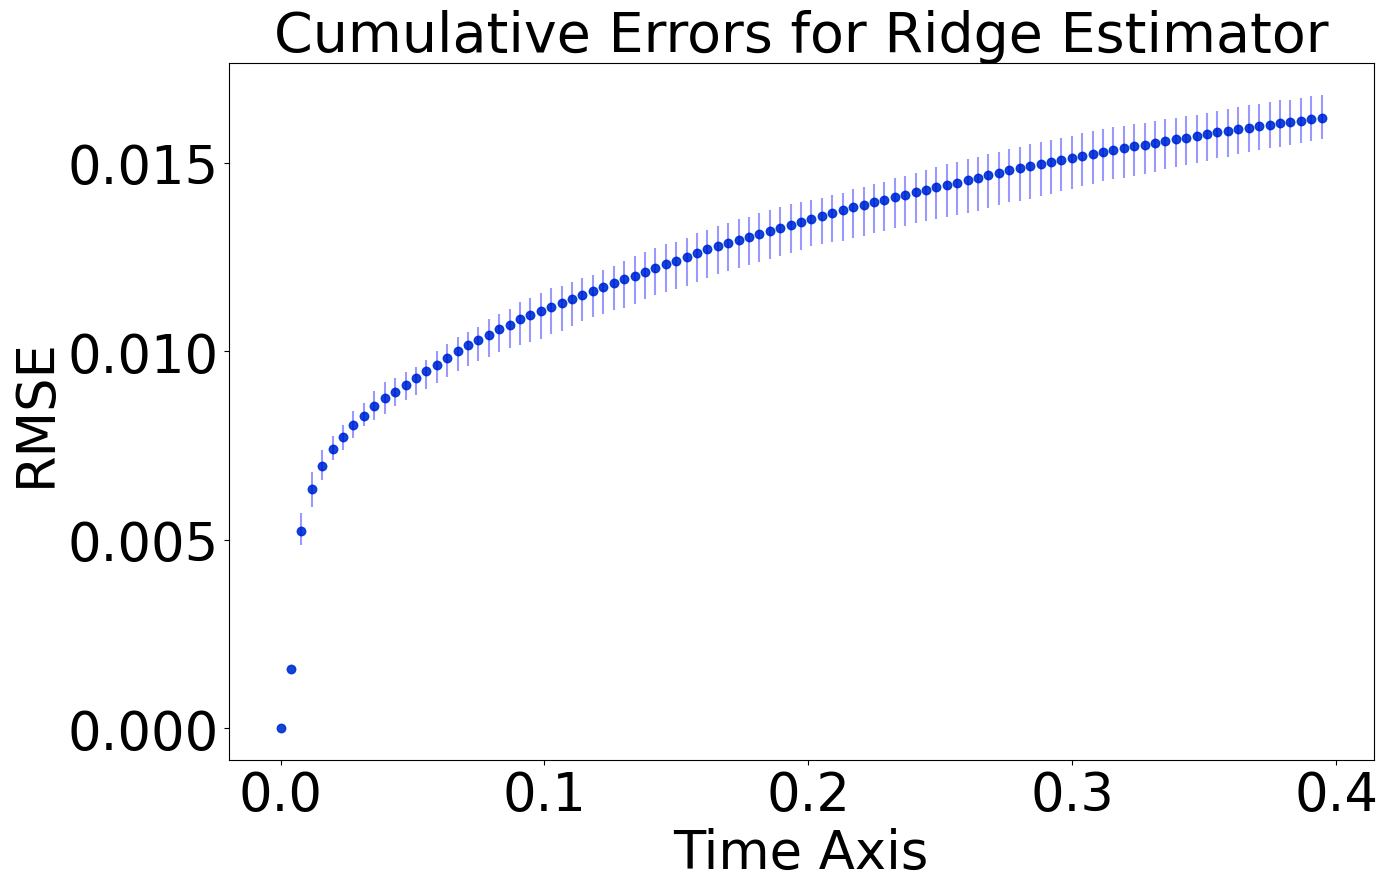

Final time cumulative RMSE local-time error 0.016194505192806206 with IQR (0.015617639100473143, 0.016804393686663067) at KN 55



In [52]:
best_rmse = np.inf
toSave = True
for k_idx in range(len(KNS)):
    KN = KNS[k_idx]
    all_true_states = np.zeros(shape=(rmse_quantile_nums, num_state_paths, 1 + num_time_steps, config.ndims))
    all_global_states = np.zeros(shape=(rmse_quantile_nums, num_state_paths, 1 + num_time_steps, config.ndims))
    all_local_states = np.zeros(shape=(rmse_quantile_nums, num_state_paths, 1 + num_time_steps, config.ndims))
    assert (all_true_states.shape == all_global_states.shape == all_local_states.shape)
    B = spline_basis(paths=paths[:num_paths,:], KN=KN, AN=AN, BN=BN, M=M)
    Z = np.power(deltaT,-1)*np.diff(paths[:num_paths,:], axis=1).reshape((paths[:num_paths,:].shape[0]*(paths.shape[1]-1),1))
    assert (B.shape[0] == Z.shape[0] and len(B.shape)==len(Z.shape) == 2)
    coeffs = find_optimal_estimator_coeffs(B=B, Z=Z, KN=KN, LN=LN, M=M)
    for quant_idx in tqdm(range(rmse_quantile_nums)):
        true_states = np.zeros(shape=(num_state_paths, 1 + num_time_steps, config.ndims))
        global_states = np.zeros(shape=(num_state_paths, 1 + num_time_steps, config.ndims))
        local_states = np.zeros(shape=(num_state_paths, 1 + num_time_steps, config.ndims))
        # Initialise the "true paths"
        true_states[:, [0], :] = config.initState
        # global_states[:, [0], :] = config.initState
        local_states[:, [0], :] = config.initState

        for i in (range(1, num_time_steps + 1)):
            eps = np.random.randn(num_state_paths, 1, config.ndims) * np.sqrt(deltaT)
            assert (eps.shape == (num_state_paths, 1, config.ndims))
            true_mean = true_drift(true_states[:, i - 1, :], num_paths=num_state_paths, config=config)
            # global_basis = spline_basis(paths=global_states[:, i - 1, :], KN=KN, AN=AN, BN=BN, M=M)
            # global_mean = construct_estimator(coeffs=coeffs, B=global_basis, LN=LN)[:, np.newaxis, :]
            local_basis = spline_basis(paths=true_states[:, i - 1, :], KN=KN, AN=AN, BN=BN, M=M)
            local_mean = construct_estimator(coeffs=coeffs, B=local_basis, LN=LN)[:, np.newaxis, :]
            true_states[:, [i], :] = true_states[:, [i - 1], :] + true_mean * deltaT + eps
            # global_states[:, [i], :] = global_states[:, [i - 1], :] + global_mean * deltaT + eps
            local_states[:, [i], :] = true_states[:, [i - 1], :] + local_mean * deltaT + eps
        all_true_states[quant_idx, :, :, :] = true_states
        all_local_states[quant_idx, :, :, :] = local_states
    all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2)/config.deltaT, axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
    total_local_errors = np.mean(np.sqrt(all_local_errors), axis=0)
    total_local_errors_minq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.025)
    total_local_errors_maxq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.975)
    print(total_local_errors[-1], (total_local_errors_minq[-1], total_local_errors_maxq[-1]), best_rmse)
    if total_local_errors[-1]  < best_rmse:
        time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
        best_rmse = total_local_errors[-1] #- total_local_errors_minq[-1]
        fig, ax = plt.subplots(figsize=(14,9))
        ax.scatter(time_steps, total_local_errors)
        plt.errorbar(time_steps,total_local_errors,yerr=[total_local_errors-total_local_errors_minq, total_local_errors_maxq-total_local_errors],xerr=None, fmt='o', color="blue", alpha=0.4)
        ax.set_title(f"Cumulative Errors for Ridge Estimator",fontsize=40)
        ax.set_ylabel("RMSE", fontsize=38)
        ax.set_xlabel("Time Axis", fontsize=38)
        ax.tick_params(labelsize=38)
        plt.tight_layout()
        if toSave:
            save_path = f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/"
            #for f in os.listdir(save_path):
            #    if "Ridge_DriftTrack_fQuadSinHF_" in f and f"{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c" in f:
            #        os.remove(save_path + f)
            plt.savefig(save_path + (f"Ridge_DriftTrack_fQuadSinHF_{KN}KN_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c.png").replace(".", ""),  bbox_inches='tight')
        plt.show()
        plt.close()
        print(f"Final time cumulative RMSE local-time error {total_local_errors[-1]} with IQR {(total_local_errors_minq[-1], total_local_errors_maxq[-1])} at KN {KN}\n")
